Importing necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import json
import requests
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

In [2]:
data = pd.read_csv("data/kc_house_data.csv")

In [3]:
df = pd.DataFrame(data)

In [4]:
len(df.columns)

21

In [5]:
len(df)

21597

Investigating placeholder and nan values

In [6]:
col_list = list(df.columns)
for col in col_list:
    print(df[col].value_counts())

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64
6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
            ... 
5/24/2015      1
11/2/2014      1
5/27/2015      1
1/10/2015      1
3/8/2015       1
Name: date, Length: 372, dtype: int64
350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64
3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64
2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.

In [7]:
df = df[df["sqft_basement"] != '?']

In [8]:
df["sqft_basement"] = df["sqft_basement"].astype(float)

In [9]:
date_time_str = "10/13/2014"

In [10]:
date_time_obj = datetime.strptime(date_time_str, '%m/%d/%Y')

In [11]:
df["date"] = df["date"].map(lambda date: datetime.strptime(date, '%m/%d/%Y'))

In [12]:
df['date']=df['date'].map(datetime.toordinal)

In [13]:
df["waterfront"] = df["waterfront"].astype(str)

In [14]:
df.drop(columns = "view", inplace = True)

Investigating distribution of variables

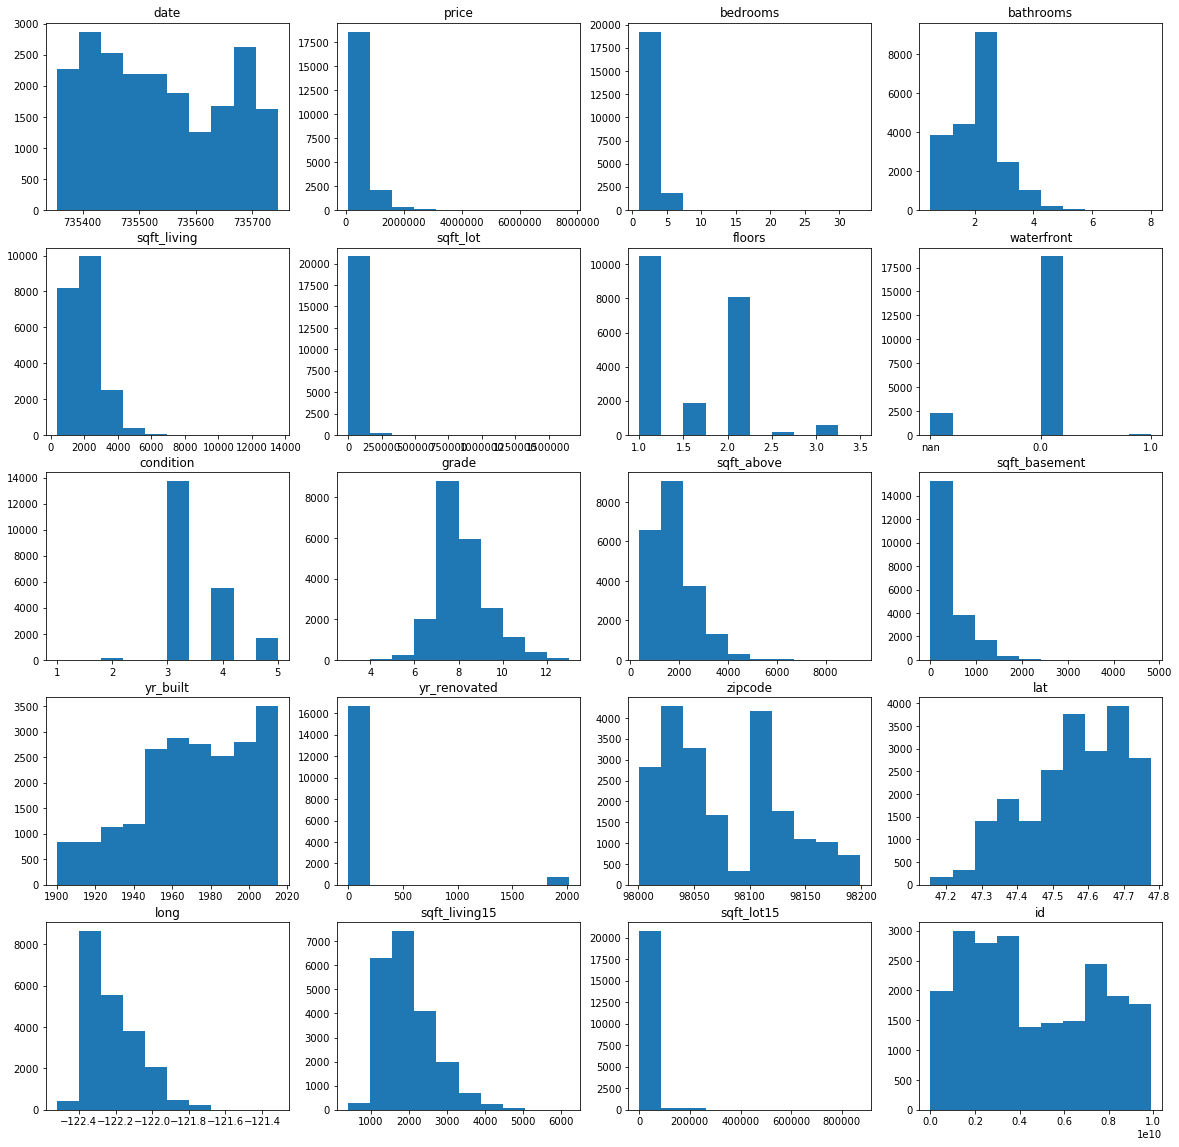

In [15]:
fig, axes = plt.subplots(nrows=5, ncols=4,figsize=(20,20))
plt.title('Graphs')
x = df.price
for n in range(len(df.columns)):
    row=(n-1)//4
    col=n%4-1
    ax=axes[row][col]
    y=df.iloc[:,n]
    ax.hist(y)
    ax.set_title(df.columns.values[n])
plt.show()   

Investigating independent vs dependent variable relationships via scatterplots

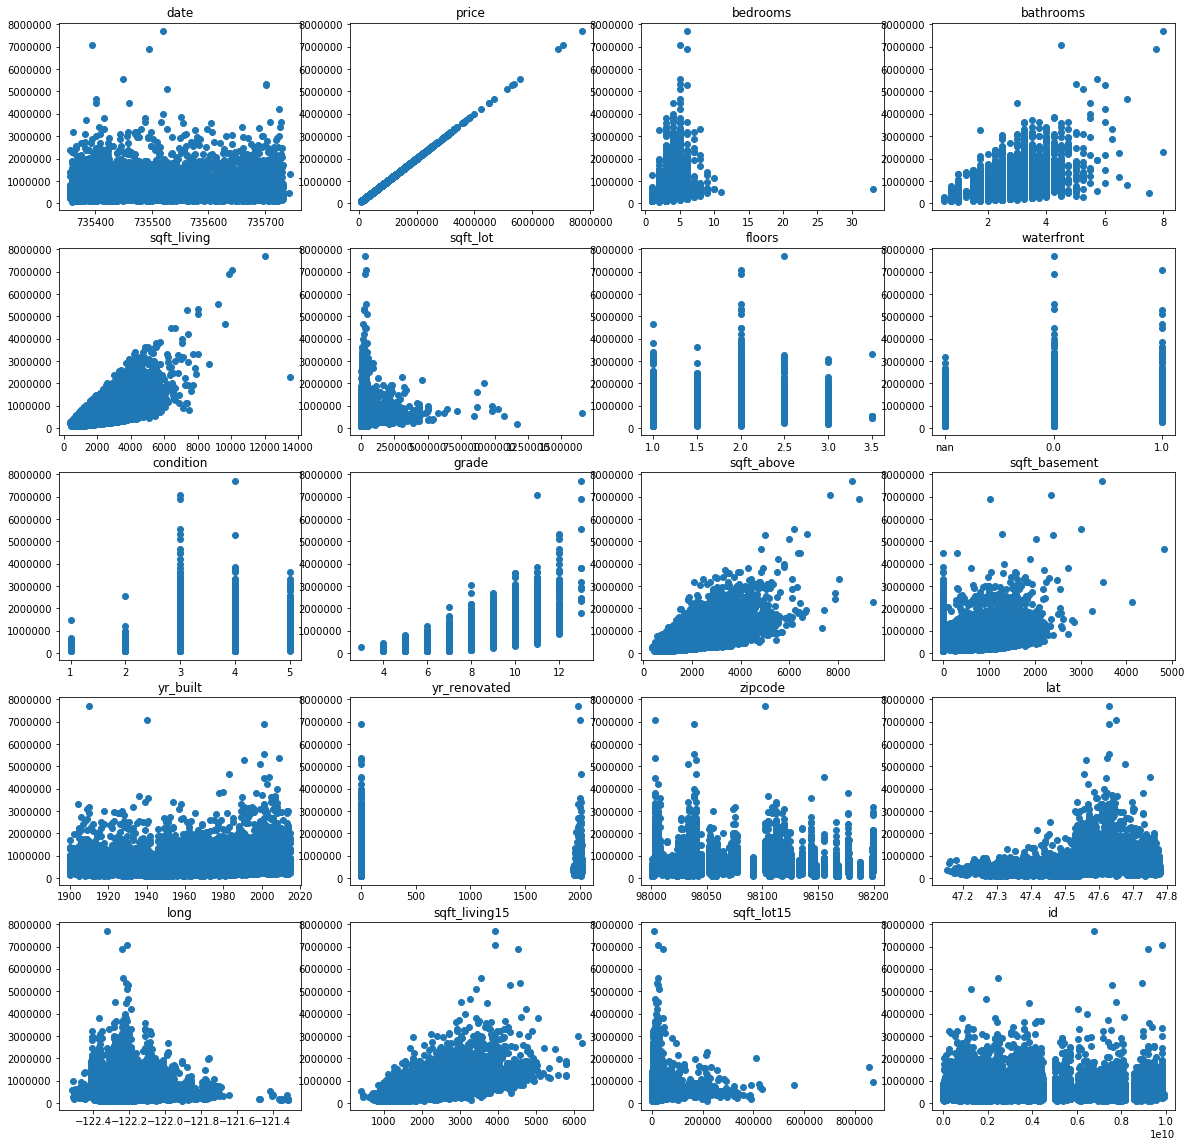

In [16]:
fig, axes = plt.subplots(nrows=5, ncols=4,figsize=(20,20))
plt.title('Graphs')
for n, column in enumerate(df.columns):
    row=(n-1)//4
    col=n%4-1
    ax=axes[row][col]
    x=df[column]
    y=df.price
    ax.scatter(x, y)
    ax.set_title(df.columns.values[n])
plt.show()   

In [17]:
top_zips = list(df.groupby("zipcode").median()["price"].sort_values(ascending = False)[:20].index)

In [18]:
df["zipcode"].value_counts()

98103    588
98038    574
98115    568
98052    562
98042    542
        ... 
98102    100
98010     98
98024     79
98148     55
98039     49
Name: zipcode, Length: 70, dtype: int64

In [19]:
df_top_zip = df[df["zipcode"].isin(top_zips)]

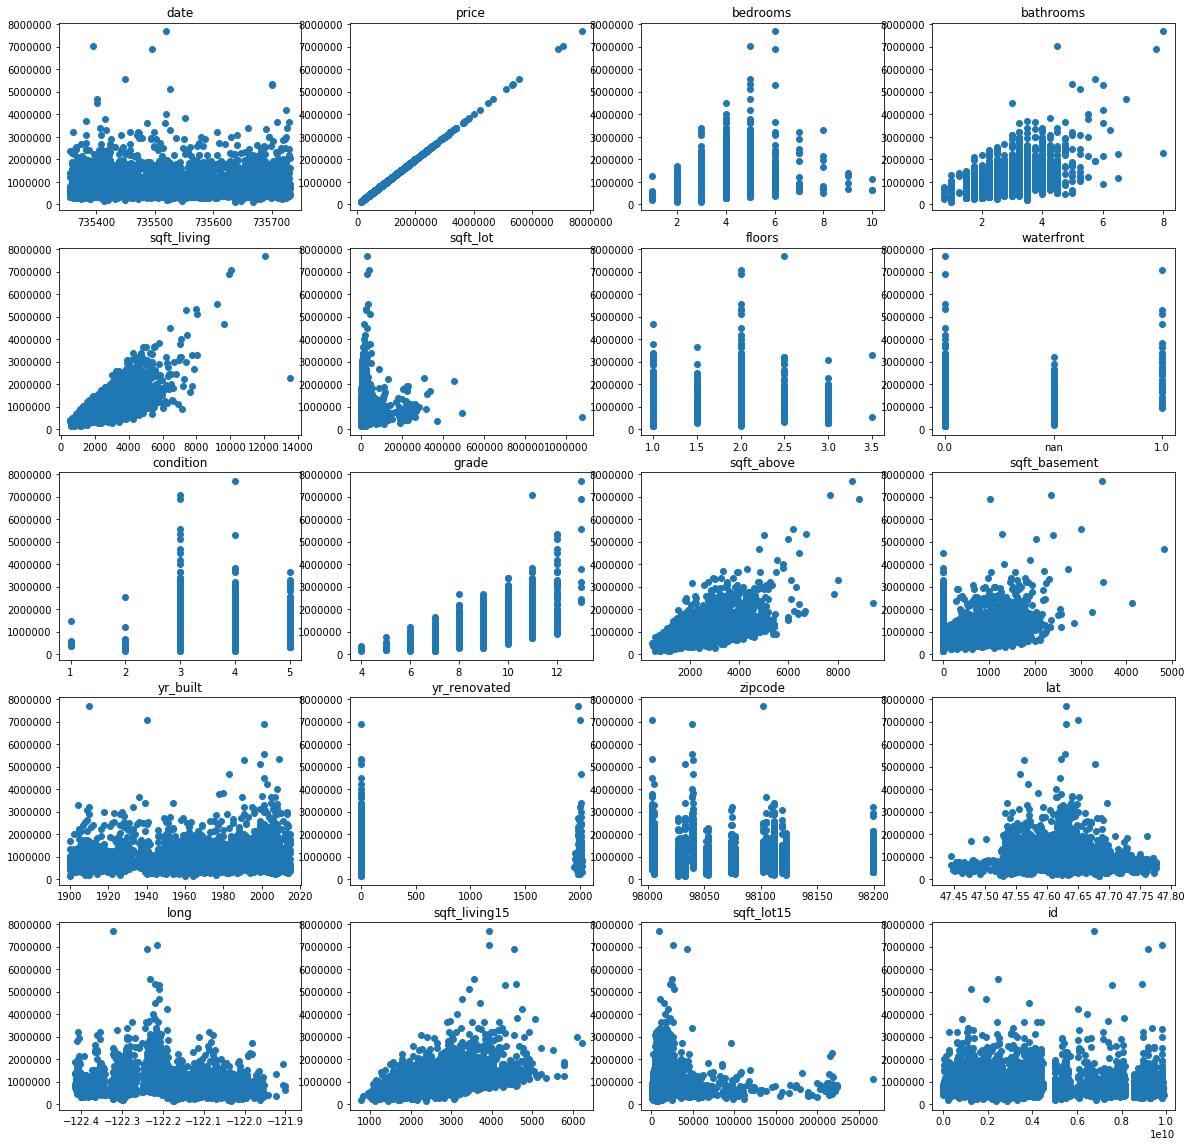

In [20]:
fig, axes = plt.subplots(nrows=5, ncols=4,figsize=(20,20))
plt.title('Graphs')
for n, column in enumerate(df_top_zip.columns):
    row=(n-1)//4
    col=n%4-1
    ax=axes[row][col]
    x=df_top_zip[column]
    y=df_top_zip.price
    ax.scatter(x, y)
    ax.set_title(df_top_zip.columns.values[n])
plt.show()   

Investigating multicollinearity

In [21]:
correlation_df = df.corr()
correlation_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,0.004709,-0.015796,0.002487,0.006120,-0.011721,-0.132268,0.019281,-0.023186,0.008681,-0.010567,-0.004548,0.022218,-0.010601,-0.011183,-0.004728,0.021373,-0.003039,-0.138005
date,0.004709,1.000000,-0.002960,-0.015479,-0.032192,-0.032251,0.006115,-0.021661,-0.049604,-0.037659,-0.025646,-0.018934,0.000561,-0.025455,0.001498,-0.033544,-0.006851,-0.029806,0.003082
price,-0.015796,-0.002960,1.000000,0.309204,0.525889,0.702328,0.087937,0.256355,0.035290,0.667738,0.605143,0.325008,0.054459,0.128227,-0.053166,0.306507,0.022101,0.586415,0.083192
bedrooms,0.002487,-0.015479,0.309204,1.000000,0.513840,0.577998,0.032262,0.179044,0.025710,0.356882,0.479210,0.302683,0.157017,0.019060,-0.152628,-0.009521,0.131093,0.392476,0.030479
bathrooms,0.006120,-0.032192,0.525889,0.513840,1.000000,0.755278,0.087884,0.504071,-0.128015,0.666493,0.686456,0.282693,0.508408,0.051736,-0.204306,0.024994,0.224479,0.570129,0.088834
sqft_living,-0.011721,-0.032251,0.702328,0.577998,0.755278,1.000000,0.172941,0.354688,-0.061294,0.763101,0.876678,0.434576,0.319461,0.054291,-0.198906,0.052986,0.240797,0.756389,0.184466
sqft_lot,-0.132268,0.006115,0.087937,0.032262,0.087884,0.172941,1.000000,-0.007522,-0.009671,0.113402,0.183461,0.015533,0.052768,0.003491,-0.129355,-0.085457,0.230583,0.143428,0.720649
floors,0.019281,-0.021661,0.256355,0.179044,0.504071,0.354688,-0.007522,1.000000,-0.264280,0.459214,0.524225,-0.245144,0.489665,0.003256,-0.058976,0.048977,0.125922,0.280294,-0.011545
condition,-0.023186,-0.049604,0.035290,0.025710,-0.128015,-0.061294,-0.009671,-0.264280,1.000000,-0.148508,-0.159289,0.170972,-0.362107,-0.062261,0.003437,-0.015592,-0.106285,-0.093493,-0.004860
grade,0.008681,-0.037659,0.667738,0.356882,0.666493,0.763101,0.113402,0.459214,-0.148508,1.000000,0.756382,0.168023,0.448120,0.016907,-0.185131,0.113380,0.199187,0.713574,0.121921


In [22]:
correlation_df.applymap(lambda val: abs(val) >= 0.75)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
date,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,False,True,True,False,False,False,True,True,False,False,False,False,False,False,True,False
sqft_lot,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False


In [23]:
corr_data = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr_data[corr_data[0] < 1][:20]

,level_0,level_1,0
195,sqft_above,sqft_living,0.876678
105,sqft_living,sqft_above,0.876678
104,sqft_living,grade,0.763101
176,grade,sqft_living,0.763101
328,sqft_living15,sqft_living,0.756389
112,sqft_living,sqft_living15,0.756389
181,grade,sqft_above,0.756382
199,sqft_above,grade,0.756382
99,sqft_living,bathrooms,0.755278
81,bathrooms,sqft_living,0.755278


It appears that there is strong correlation between:
 - sqft living/sqft above
 - sqft living/grade
 - sqft living 15/sqft living
 - grade/sqft above
 - bathrooms/sqft living

Further investigating multicollinearity of subset of independent variables

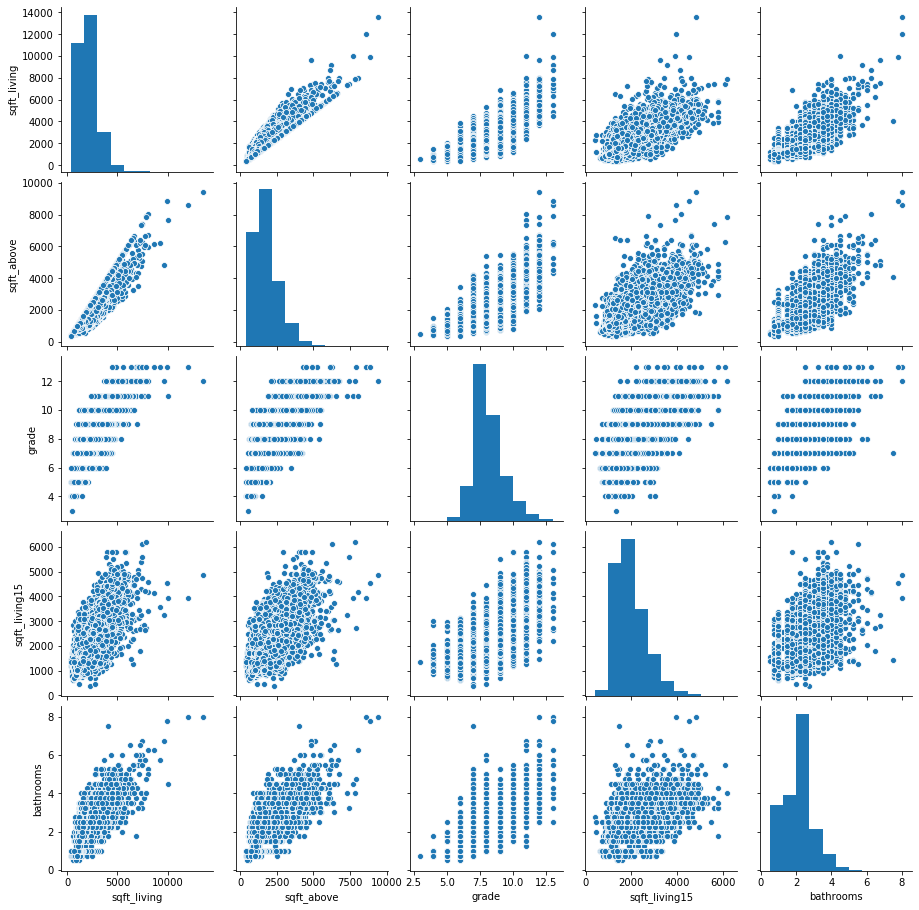

In [24]:
sns.pairplot(df[["sqft_living", "sqft_above", "grade", "sqft_living15", "bathrooms"]])

Creating dummy variables for categorical data so they can be read into model

In [25]:
categorical = ["waterfront", "condition", "grade", "floors", "bedrooms", "zipcode"]
continuous = ["id", "date", "price", "bathrooms", "sqft_living", "sqft_lot", "sqft_above", "sqft_basement", "yr_built", "lat", "long", "sqft_living15", "sqft_lot15"]

** year renovated was not included in categorical list, as it was added manually as a dummy variable

Creating dummy variables for year renovated

In [26]:
df["reno_2000_over"] = df["yr_renovated"].map(lambda year: 1 if year >= 2000 else 0)

In [27]:
df["reno_1980_2000"] = df["yr_renovated"].map(lambda year: 1 if (year >= 1980 and year < 2000) else 0)

In [28]:
df["reno_1960_1980"] = df["yr_renovated"].map(lambda year: 1 if (year >= 1960 and year < 1980) else 0)

In [29]:
df["reno_1940_1960"] = df["yr_renovated"].map(lambda year: 1 if (year >= 1940 and year < 1960) else 0)

In [30]:
df["reno_1920_1940"] = df["yr_renovated"].map(lambda year: 1 if (year >= 1920 and year < 1940) else 0)

In [31]:
df["reno_never"] = df["yr_renovated"].map(lambda year: 1 if year == 0 else 0)

In [32]:
df["yr_renovated"].fillna("nan")

0           0
1        1991
2         nan
3           0
4           0
         ... 
21592       0
21593       0
21594       0
21595       0
21596       0
Name: yr_renovated, Length: 21143, dtype: object

In [33]:
df["reno_nan"] = df["yr_renovated"].map(lambda year:  1 if np.isnan(year) else 0)

In [34]:
df_nona = df.drop(columns = ["yr_renovated", "reno_nan"])

In [35]:
df_cat = pd.DataFrame([])

for col in categorical:
    df_cat = pd.concat([df_cat, pd.get_dummies(df_nona[col], prefix= col[:3], drop_first=True)], axis=1)

In [36]:
df_cat

,wat_1.0,wat_nan,con_2,con_3,con_4,con_5,gra_4,gra_5,gra_6,gra_7,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21593,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
21594,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
21595,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df_joined = pd.concat([df_nona, df_cat], axis=1)

In [38]:
df_joined.drop(columns = categorical, axis=1, inplace = True)

In [39]:
df["date"].astype(float)

0        735519.0
1        735576.0
2        735654.0
3        735576.0
4        735647.0
           ...   
21592    735374.0
21593    735652.0
21594    735407.0
21595    735614.0
21596    735521.0
Name: date, Length: 21143, dtype: float64

Exporting data to csv

In [40]:
df_joined.to_csv("data/df_joined.csv", index=False)